In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize

from sivqed.models.siv import SiV
from sivqed.models.cavity import Cavity, CavitySiV

plt.rcParams['font.size'] = 18

# Replicate Fig 2b in PRL Nguyen 123 (2019)

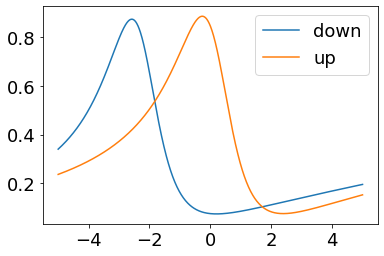

In [3]:
# Values taken from fitting notebook SSR Rabi.nb
# NOTE: requires the alternate formula for reflectance to look the sanme
c = Cavity({"w_c" : -12.6126,    
            "k_in" : 12.2252, 
            "k_tot" : 33.0766}, 
              
           {"w_up" : -0.205697,          
            "g_up" : 6.15004,         
            "gamma_up" : 0.1,  

            "w_down" : -2.53141,       
            "g_down" : 5.82265,       
            "gamma_down" : 0.1})

w_arr = np.linspace(-5, 5, 1000)
plt.plot(w_arr, c.reflectance(w_arr, 0), label="down")
plt.plot(w_arr, c.reflectance(w_arr, 1), label="up")
plt.legend()

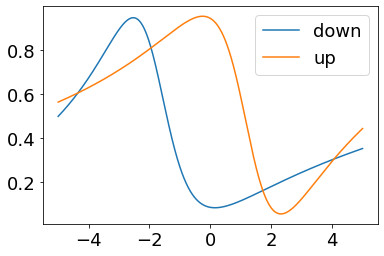

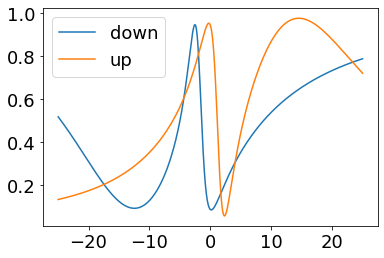

In [4]:
# Function and values taken from fitting notebook SSR Rabi (Mihir Bhaskar's conflicted copy 2019-03-20).nb
def t_function(w, w_a, delta, g, gamma, k, alpha, phi, B):
    t = np.sqrt(k) / (1j * (w - w_a - delta) + (k / 2) + g ** 2 / (1j * (w - w_a) + (gamma / 2))) + alpha * np.exp(1j * phi)
    return B * (t * t.conjugate()).real

w_arr = np.linspace(-5, 5, 1000)
plt.plot(w_arr, t_function(w=w_arr, w_a=-2.61589, delta=-8.56955, g=5.27, gamma=0.1, k=33.1, alpha=-0.26693, phi=-0.0636794, B=14.3136), label="down")
plt.plot(w_arr, t_function(w=w_arr, w_a=2.03911, delta=7.77476, g=5.27, gamma=0.1, k=33.1, alpha=-0.115794, phi=2.39099, B=4.95673), label="up")
plt.legend()

plt.figure()
w_arr = np.linspace(-25, 25, 1000)
plt.plot(w_arr, t_function(w=w_arr, w_a=-2.61589, delta=-8.56955, g=5.27, gamma=0.1, k=33.1, alpha=-0.26693, phi=-0.0636794, B=14.3136), label="down")
plt.plot(w_arr, t_function(w=w_arr, w_a=2.03911, delta=7.77476, g=5.27, gamma=0.1, k=33.1, alpha=-0.115794, phi=2.39099, B=4.95673), label="up")
plt.legend()

## Optimization of overcoupled cavity

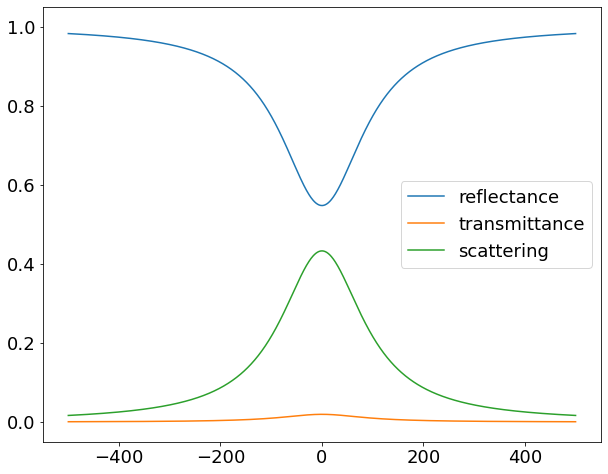

In [7]:
# From Erik's scan:
# Q_in = 3000
# Q_out = 466000
# Q_scat = 20000
# We want overall linewidth ~ 100 GHz, so we set k_tot = 100
# We assign the other kappas according to inverse ratio with the Q factors
# Assume k_scat + k_in = k_tot since k_out is small

# Other relevant parameters (g_up, gamma_up) use the default values from Cavity()
c = Cavity(cavity_params={        
            "k_in" : 87, # 260869 / 3000
            "k_out": 0.56, # 260869 / 466000 = 0.56
            "k_tot" : 100, # 260869 * (1/3000 + 1/20000) = 100
})

w_arr = np.linspace(-500, 500, 1000)
plt.figure(figsize=[10, 8])
plt.plot(w_arr, c.reflectance(w_arr, -1), label="reflectance")
plt.plot(w_arr, c.transmittance(w_arr, -1), label="transmittance")
plt.plot(w_arr, 1-c.transmittance(w_arr, -1)-c.reflectance(w_arr, -1), label="scattering")
plt.ylim([-0.05, 1.05])
plt.legend()

In [8]:
# Gives the contrast between the empty and coupled cavity at an arbitrary transition frequency w_up and frequency w.
c.empty_contrast(w=80.1, w_up=80)

1.4072528128225599

Optimum contrast of 21.9 achieved at freq = -1.33e+02, w_up = -1.33e+02
Empty reflectivity = 0.837, SiV reflectivity = 8.02e-05


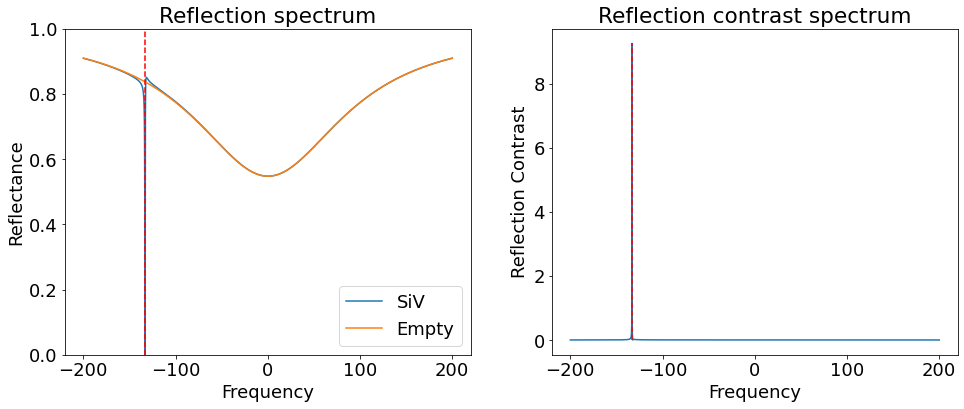

In [9]:
# Optimize for the contrast of an emitter compared to an empty cavity
# We vary the transition frequency w_up and the laser frequency w.
(w_opt, w_up_opt), contrast_empty_opt = c.optimize_empty_contrast(w_0=-100, w_up_0=-100, w_bounds=(-500, 500), w_up_bounds=(-500, 500))

print("Optimum contrast of {:.3} achieved at freq = {:.3}, w_up = {:.3}".format(contrast_empty_opt, w_opt, w_up_opt))
c.plot_reflection_contrast_empty(np.linspace(-200, 200, 20000), w_up_opt)

# SiV Class Energy Plotting Test

Ground state splitting at 0 field is 98.6
D:\Qi\Documents\Research\Codes\sivqed\models\siv.py:283: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


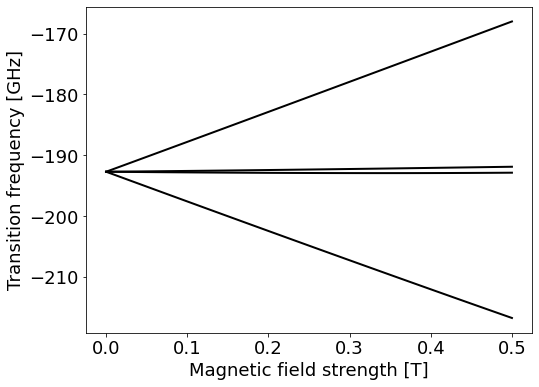

In [10]:
s = SiV(alpha_e=125, beta_e=125, alpha_g=20, beta_g=20)

# Sweep across B field strength for a given axis 
B_axis = np.array([1, 0, 0])
B_strength_sweep = np.linspace(0, 0.5, 40)

# (3 x N)-shaped arary for the set of B-field vectors in sweep
B_sweep = np.outer(B_strength_sweep, B_axis).T
bands, states = s.sweep_B_field_eigenenergies(B_sweep, plot=False) # Compute energies
s.sweep_B_field_transitions(B_sweep, frozen=True)

# Ground state splitting at 0 field: used as a characterisation of strain value
delta_gs = bands[0, 0, -1] - bands[0, 0, 0]
print("Ground state splitting at 0 field is {:.3}".format(delta_gs)) 

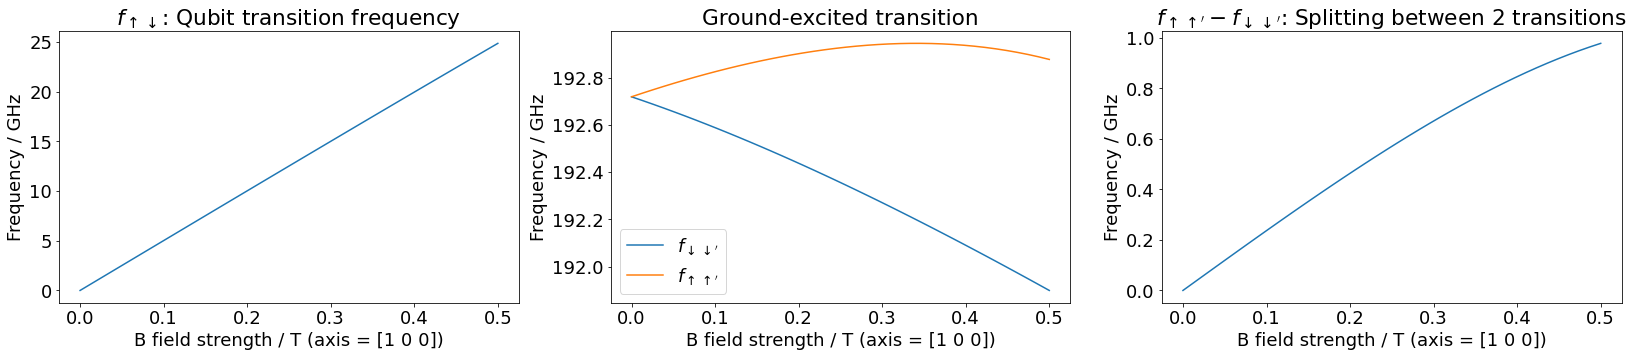

In [11]:
plt.figure(figsize=[28, 5])

# Ground-ground spin transition between lowest and 2nd-lowest
gg_up_down = bands[0, :, 1] - bands[0, :, 0]
plt.subplot(1, 3, 1)
plt.title("$f_{\\uparrow\\downarrow}$: Qubit transition frequency")
plt.xlabel("B field strength / T (axis = {})".format(B_axis))
plt.ylabel("Frequency / GHz")
plt.plot(B_strength_sweep, gg_up_down)

# Ground-excited transition between lowest-lowest and 2nd-2nd bands (down-down, up-up)
ge_down_down = bands[0, :, 0] - bands[1, :, 0]
ge_up_up = bands[0, :, 1] - bands[1, :, 1]
plt.subplot(1, 3, 2)
plt.title("Ground-excited transition")
plt.xlabel("B field strength / T (axis = {})".format(B_axis))
plt.ylabel("Frequency / GHz")
plt.plot(B_strength_sweep, ge_down_down, label="$f_{\\downarrow\\downarrow'}$")
plt.plot(B_strength_sweep, ge_up_up, label="$f_{\\uparrow\\uparrow'}$")
plt.legend()

# Ground-excited transition difference between lowest-lowest and 2nd-2nd bands (up-up minus down-down)
plt.subplot(1, 3, 3)
plt.title("$f_{\\uparrow\\uparrow'} - f_{\\downarrow\\downarrow'}$: Splitting between 2 transitions")
plt.xlabel("B field strength / T (axis = {})".format(B_axis))
plt.ylabel("Frequency / GHz")
plt.plot(B_strength_sweep, ge_up_up - ge_down_down)

In [12]:
s.dipole_transitions(B_sweep)
print("B axis = {}".format(B_axis))

TypeError: operand 'Qobj' does not support ufuncs (__array_ufunc__=None)

# Parameter optimization to maximize contrast
## Primitive optimization - sweep over parameters by hand
### Sweep only B field along x-axis

Maximum contrast = 0.247 located at frequency 0.706
Lower reflectivity = 0.526, higher reflectivity = 0.329
Applied field = 0.5, detuning = -16.5


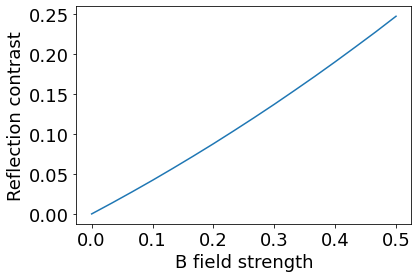

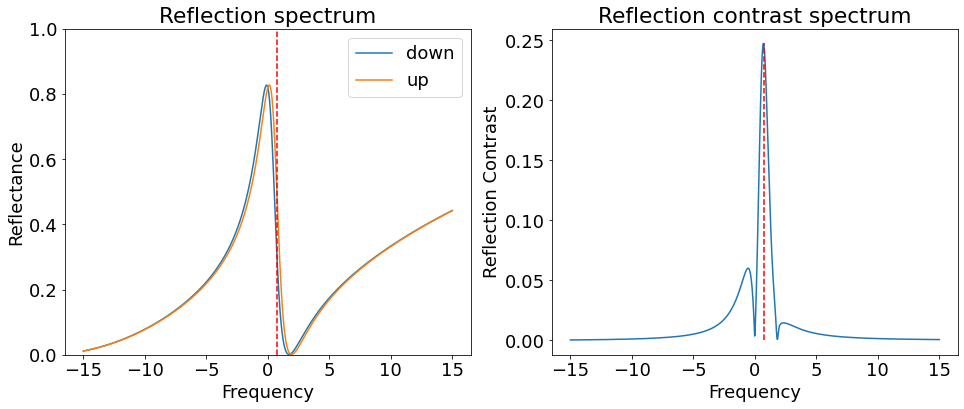

In [13]:
# Strain = 0
s = SiV()
c = CavitySiV(siv=s)

w_arr = np.linspace(-15, 15, 1000)
delta = -0.5 * 33 # Fixed value here for now

# Sweep over this range of B
B_arr = np.linspace(0, 0.5, 16)
B_axis = np.array([0, 0, 1])

contrast = np.array([max(c.spin_contrast(w_arr, B, delta, B_axis)) for B in B_arr])

# Get the contrast for each value of B, Here the max in max_contrast refers to the max value within each 
# spectrum (i.e. at a particular point of freq), and does not refer to the max across B field values.
# contrast = np.array([c.max_contrast(B, delta, B_axis) for B in B_arr])

plt.plot(B_arr, contrast)
plt.xlabel("B field strength")
plt.ylabel("Reflection contrast")

w_arr = np.linspace(-15, 15, 1000)
c.plot_reflection_contrast(w_arr, B_arr[np.argmax(contrast)] * B_axis, delta)
print("Applied field = {:.3}, detuning = {:.3}".format(B_arr[np.argmax(contrast)], delta))

Maximum contrast = 1.86 located at frequency 0.375
Lower reflectivity = 0.0329, higher reflectivity = 0.629
Applied field = 0.5, detuning = -16.5


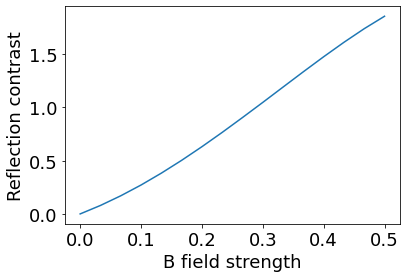

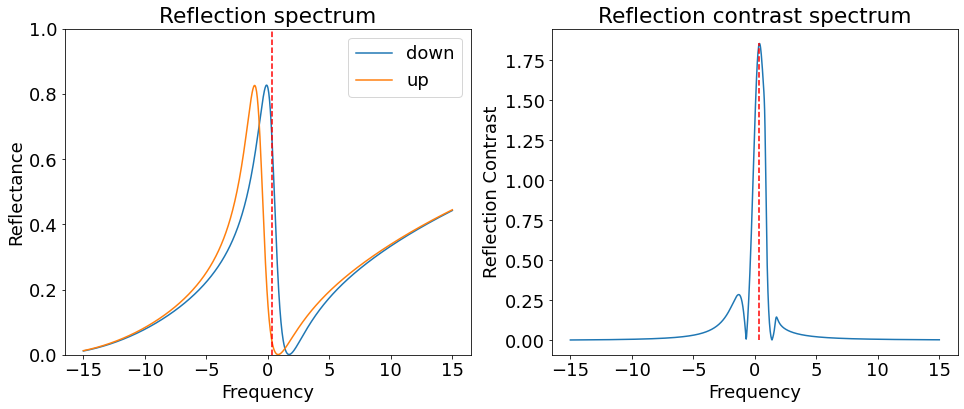

In [14]:
# Strain nonzero
s = SiV(alpha_e=125, beta_e=125, alpha_g=20, beta_g=20)
c = CavitySiV(siv=s)

w_arr = np.linspace(-15, 15, 1000)
delta = -0.5 * 33 # Fixed value here for now

# Sweep over this range of B
B_arr = np.linspace(0, 0.5, 16)
B_axis = np.array([1, 0, 0])

# Get the contrast for each value of B, Here the max in max_contrast refers to the max value within each 
# spectrum (i.e. at a particular point of freq), and does not refer to the max across B field values.
contrast = np.array([max(c.spin_contrast(w_arr, B, delta, B_axis)) for B in B_arr])

plt.plot(B_arr, contrast)
plt.xlabel("B field strength")
plt.ylabel("Reflection contrast")

c.plot_reflection_contrast(w_arr, B_arr[np.argmax(contrast)] * B_axis, delta)
print("Applied field = {:.3}, detuning = {:.3}".format(B_arr[np.argmax(contrast)], delta))

### Sweep B field strength and axis

Maximum contrast = 1.86 located at frequency 0.375
Lower reflectivity = 0.0329, higher reflectivity = 0.629
Applied field = 0.5, theta = 1.57, phi = 1.57, axis = [6.123234e-17 1.000000e+00 6.123234e-17], detuning = -16.5


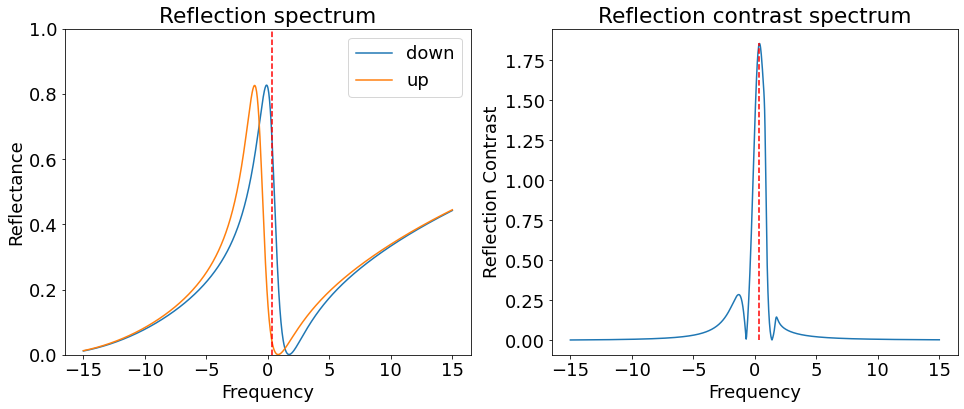

In [18]:
s = SiV(alpha_e=125, beta_e=125, alpha_g=20, beta_g=20)
c = CavitySiV(siv=s)
delta = -0.5 * 33 # Fixed value here for now

# Sweep over this range of parameters
B_arr = np.linspace(0, 0.5, 16)
theta_arr = np.linspace(0, np.pi, 5)
phi_arr = np.linspace(0, 2 * np.pi, 5)
best_contrast = 0

for B in B_arr:
    for theta in theta_arr:
        for phi in phi_arr:
            B_axis = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
            contrast = max(c.spin_contrast(w_arr, B, delta, B_axis))
            if contrast > best_contrast:
                best_B, best_theta, best_phi, best_axis = B, theta, phi, B_axis
                best_contrast = contrast

w_arr = np.linspace(-15, 15, 1000)
c.plot_reflection_contrast(w_arr, best_B * best_axis, delta)
print("Applied field = {:.3}, theta = {:.3}, phi = {:.3}, axis = {}, detuning = {:.3}".format(best_B, best_theta, best_phi, best_axis, delta))

## Automated optimization - sweep over B field and detuning

### Unbounded optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize

from sivqed.models.siv import SiV
from sivqed.models.cavity import Cavity, CavitySiV

plt.rcParams['font.size'] = 18

Optimum contrast of 4.09 achieved at freq = 0.0815, B = 0.649 and delta = -27.1
Maximum contrast = 4.04 located at frequency 0.105
Lower reflectivity = 0.00443, higher reflectivity = 0.781


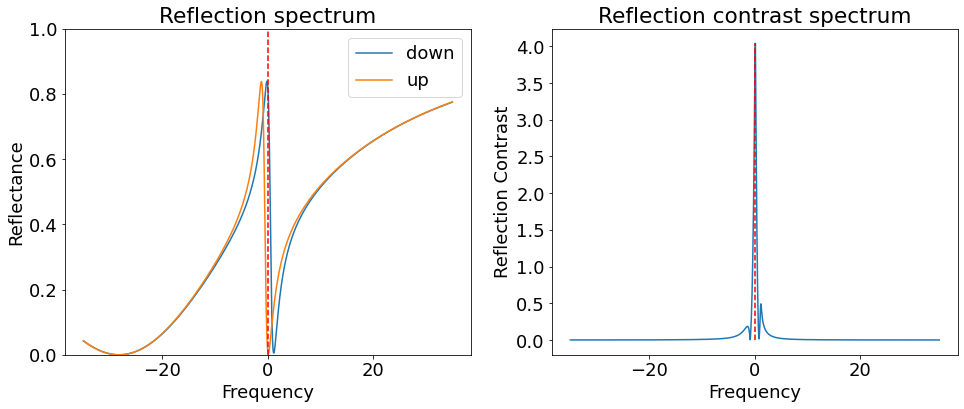

In [5]:
s = SiV(alpha_e=125, beta_e=125, alpha_g=20, beta_g=20)
B_axis = np.array([1, 0, 0])
c = CavitySiV(siv=s)

(w_opt, B_opt, delta_opt), spin_contrast_opt = c.optimize_spin_contrast(w_0=0, B_0=0.1, delta_0=-15, 
                                                                        w_bounds=(None, None), B_bounds=(None, None),
                                                                        delta_bounds=(None, None), B_axis=B_axis)

print("Optimum contrast of {:.3} achieved at freq = {:.3}, B = {:.3} and delta = {:.3}".format(spin_contrast_opt, w_opt, B_opt, delta_opt))

c.plot_reflection_contrast(np.linspace(-35, 35, 1000), B_opt * B_axis, delta_opt)

### Bounded optimization

Optimum contrast of 3.86 achieved at freq = 0.0898, B = 0.5 and delta = -29.0
Maximum contrast = 3.86 located at frequency 0.0851
Lower reflectivity = 0.00592, higher reflectivity = 0.789


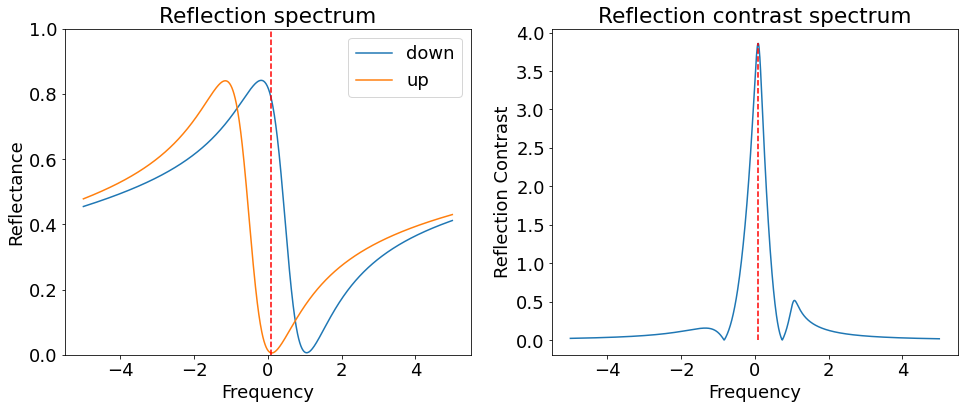

In [8]:
s = SiV(alpha_e=125, beta_e=125, alpha_g=20, beta_g=20)
B_axis = np.array([1, 0, 0])
c = CavitySiV(siv=s)

(w_opt, B_opt, delta_opt), spin_contrast_opt = c.optimize_spin_contrast(w_0=0, B_0=0.1, delta_0=-15, 
                                                                        w_bounds=(-5, 5), B_bounds=(-0.5, 0.5),
                                                                        delta_bounds=(-60, 60), B_axis=B_axis)

print("Optimum contrast of {:.3} achieved at freq = {:.3}, B = {:.3} and delta = {:.3}".format(spin_contrast_opt, w_opt, B_opt, delta_opt))

c.plot_reflection_contrast(np.linspace(-5, 5, 1000), B_opt * B_axis, delta_opt)